# Demonstration of **oceanliner**: OSSEs for SWOT in situ campaigns

This notebook enables a user to select a region from one of the 15 [Adopt-a-Crossover](https://www.swot-adac.org/) sites and specify a sampling pattern (e.g., the path of an ocean glider, ship-based underway CTD, Wave Glider, Saildrone, or mooring), and then does the following:
* download llc4320 data to the local machine
* compute steric height and potential vorticity 
* interpolate model fields in space/time over the trajectory
* return set of subsampled variables on a regular grid 
* store and plot outputs, including "true" and "subsampled" steric height 

### User inputs:
* **RegionName**: name of region (corresponding to filename) - options are WesternMed  ROAM_MIZ  NewCaledonia  NWPacific  BassStrait  RockallTrough  ACC_SMST MarmaraSea  LabradorSea  CapeBasin Boknis GotlandBasin NWAustralia WestAtlantic Yongala - [link to PO.DAAC data listings](https://podaac.jpl.nasa.gov/datasetlist?ids=Processing+Levels&values=4+-+Gridded+Model+Output&search=Pre-SWOT+llc4320&view=list&provider=)
* **start_date**, **ndays**: specify date range as start date & number of days.
* **SAMPLING_PLATFORM** : simulated platform with with to sample the model: glider track (`glider`), shipboard underway CTD (`uctd`), Wave Glider (`wave_glider`), Saildrone (`saildrone`) mooring (`mooring`), or a user-specified trajectory (`trajectory_file`), in which casea netCDF file **trajectory_file** must also be specified. Specifying a sampling platform applies realistic default values for platform speed and depth range
* **SAMPLING_PATTERN**: survey SAMPLING_PATTERN -- can be `lawnmower` or `back-forth`
* **datadir** : directory where data files are stored



### Future developments to include:
* implement other sampling platforms that interact with model current fields (e.g., drifters)
* adapt for the AWS cloud
* compute other variables of interest
* import simulated SWOT data at the same location
* pipe output into optimal interpolation software
* implement other models (including biogeochemical model)
* efficiency improvements



Code to download data from PO.DAAC adapted from [this demo](https://github.com/podaac/tutorials/blob/master/notebooks/Pre-SWOT_Numerical_Simulation_Demo.ipynb) by Jinbo Wang & Jack McNelis (JPL) 


In [17]:
## Imports

# Native packages
from math import radians, degrees, sin, cos, asin, acos, sqrt
import datetime
import time
import sys
import os

# Third-party packages for data manipulation
import numpy as np
import pandas as pd
import xarray as xr

# Other third-party packages
import netCDF4 as nc4

# Third-party packages for data interpolation
from scipy import interpolate
from scipy.interpolate import griddata
from xgcm import Grid
import xgcm.grid

# Third-party packages for data visualizations
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import axes3d
import matplotlib.dates as mdates

# osse tools package
# del sys.modules['oceanliner_functions']  # uncomment if troubleshooting oceanliner_functions
from oceanliner_functions import download_llc4320_data, compute_derived_fields, get_survey_track, survey_interp, rotate_vector_to_EN


In [13]:
# --------------------------------------------------------------------
# USER INPUTS: 
# --------------------------------------------------------------------
# *** users should only have to modify the variables in this cell ***
# --------------------------------------------------------------------


# ------------ region and time span

# RegionName: region with MITgcm llc4320 data on the PO.DAAC 
#   options are:
#     WesternMed  ROAM_MIZ  NewCaledonia  NWPacific  BassStrait  RockallTrough  ACC_SMST
#     MarmaraSea  LabradorSea  CapeBasin Boknis GotlandBasin NWAustralia WestAtlantic Yongala
RegionName = 'ACC_SMST' 

# start_date:  first date to subsample the model. 
#   MITgcm llc4320 data are from 2011-Sep-13 to 2012-Nov-15
start_date = datetime.date(2012,1,1)
# ndays: number of days over which to subsample the model (starting at start_date) 
#   note: ndays must be >1 
#   note: a large number of ndays may crash smaller machines
ndays = 5 
# --------------------------------------------------------------------


# ------------ directories -------------------------------------------

# directory where data files are stored
datadir = '/data3/llc4320/' + RegionName + '/'                     
# directory where generated output files will be stored
outputdir = '/data3/adac/osse_output/' + RegionName + '/'           
# directory where figures will be stored
figdir = '/data2/Dropbox/projects/adac/figures/' + RegionName + '/' # store figures
# --------------------------------------------------------------------




# ------------ sampling parameters ------------------------------------

# SAMPLING_PLATFORM: which instrument to sample with:
#   options are glider, uctd, mooring, wave_glider, saildrone, or trajectory_file
#   if *only* SAMPLING_PLATFORM is specified, reasonable defaults will be selected for the other parameters
SAMPLING_PLATFORM = 'glider' 

# trajectory_file: if SAMPLING_PLATFORM=trajectory_file, the waypoints of the platform's 
#   trajectoy must be supplied in the file specified by "trajectory_file", which is a 
#   netCDF files with 
trajectory_file = None

# SAMPLING_PATTERN: which default pattern/trajectory to apply
# options are back-forth (repeated back+forth betwen two waypoints) or lawnmower (radiator survey)
SAMPLING_PATTERN = 'lawnmower' # back-forth or lawnmower 

# AT_END: what to do after the end of each sampling trajectory is reached.
#  options are reverse (follow the track back to the start), repeat (restarts and then repeats) or terminate (stop) 
AT_END = 'reverse'

# zrange: depth range of measurements as a 2-element list. 
#   * note, if depth values are negative (As in MITgcm), zrange should be negative
zrange = [-1, -1000]

# z_res: vertical sampling resolution in m
z_res = 1

# hspeed: horizontal speed of the platform (in m/s) 
hspeed = 0.25

# vspeed: vertical speed of the platform through the water (in m/s)
#   for glider, this is the speed at which the glider dives
#   for uctd, this is the fall-rate of the instrument
#   for mooring, wave_glider and saildrone vspeed is irrelevant
vspeed = 0.1

# xmooring, ymooring, zmooring: for SAMPLING_PLATFORM=mooring, 
#   specify the lon/lat of the mooring and the depth of the instruments
#   (default x/y is the center of the domain)
xmooring = []
ymooring = []
zmooring = [-1, -10, -50, -500, -1000]
      

# DERIVED_VARIABLES: whether or not to compute the "derived variables" - steric height, rotated velocity, vorticity
#  it takes significant memory and time to derive and save the stored variables, so False is recommended unless these
#  variables are needed
DERIVED_VARIABLES = {'vorticity', 'steric_height'} # or, None

# --------------------------------------------------------------------




# ------------ save flags ------- ------------------------------------

# SAVE_FIGURES: if True, save some basic figures
SAVE_FIGURES = False 

# SAVE_PRELIMINARY: if True, save preliminary along-track data. 
#  This takes more space but is faster and less prone to crashing than the gridding step
SAVE_PRELIMINARY = False 


In [3]:
## store the user-specified details in "sampling_details" variable

sampling_details = {
   'SAMPLING_PLATFORM' : SAMPLING_PLATFORM,
    'SAMPLING_PATTERN' : SAMPLING_PATTERN,
    'zrange' : zrange,  
    'z_res' : z_res,
    'hspeed' : hspeed,
    'vspeed' : vspeed,
    'AT_END' : AT_END,
    'xmooring' : xmooring,
    'ymooring' : ymooring,
    'zmooring' : zmooring,
    'DERIVED_VARIABLES' : DERIVED_VARIABLES,
    'SAVE_PRELIMINARY' : SAVE_PRELIMINARY,
    'start_date' : start_date,
    'ndays' : ndays
}


#### Download & load model data and derived fields

Based on [LLC4320](https://data.nas.nasa.gov/viz/vizdata/llc4320/index.html), the 1/48-degree global MITgcm simulation produced by the ECCO project. Ten regional cut-outs of the simulation are available on the [PO.DAAC](https://podaac.jpl.nasa.gov/datasetlist?ids=Processing+Levels&values=4+-+Gridded+Model+Output&search=Pre-SWOT+llc4320&view=list&provider=); the 4x4 degree regional domains are small enough to enable fairly easy downloads and processing. 

In [4]:
# download files:
download_llc4320_data(RegionName, datadir, start_date, ndays)

# derive & save new files with steric height & vorticity
if sampling_details['DERIVED_VARIABLES']:
    compute_derived_fields(RegionName, datadir, start_date, ndays)

#### Load all model data files. 


In [22]:
%%time
date_list = [start_date + datetime.timedelta(days=x) for x in range(ndays)]
target_files = [f'{datadir}LLC4320_pre-SWOT_{RegionName}_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)] # list target files

# open the dataset
ds = xr.open_mfdataset(target_files)

# XC, YC and Z are the same at all times, so select a single time
# (note, this breaks for a single file - always load >1 file)
X = ds.XC.isel(time=0) 
Y = ds.YC.isel(time=0)

CPU times: user 248 ms, sys: 0 ns, total: 248 ms
Wall time: 247 ms


### Rotate vector quantities if needed

At higher latitudes, vector quantities (U/V/TAU_U/TAU_V) are in model coordinates and must be rotated to earth coordinates
rotation vectors are given in AngleSN, AngleCS

In [23]:
# checking if AngleSN variable exists (if AngleSN exists then AngleCS should also exist so need to check for AngleCS)
angles = "AngleSN"
ls = list(ds.data_vars)
matches = [match for match in ls if angles  in match]

if (matches):
    print('Rotating vector quantities to east/north')
    
    # first, interpolate U,V and oceTAUX, oceTAUY to the tracer grid
    # and rotate them to geophysical (east, north) coordinates instead of model ones:
    # 1) interpolate U,V and oceTAUX, oceTAUY to the tracer grid 
    print('interpolating to tracer grid')
    # define grid
    grid = xgcm.Grid(ds, coords={'X':{'center': 'i', 'left': 'i_g'}, 
                         'Y':{'center': 'j', 'left': 'j_g'},
                         'T':{'center': 'time'},
                         'Z':{'center': 'k'}})    
    U_c = grid.interp(ds.U, 'X', boundary='extend')
    V_c = grid.interp(ds.V, 'Y', boundary='extend')
    # do the same for TAUX and TAUY:
    oceTAUX_c = grid.interp(ds.oceTAUX, 'X', boundary='extend')
    oceTAUY_c = grid.interp(ds.oceTAUY, 'Y', boundary='extend')

    # 2) rotate them to geophysical (east, north) coordinates instead of model ones using rotate_vector_to_EN:
    print('rotating to east/north')
    U_transformed, V_transformed = rotate_vector_to_EN(U_c, V_c, ds['AngleCS'], ds['AngleSN'])
    oceTAUX_transformed, oceTAUY_transformed = rotate_vector_to_EN(oceTAUX_c, oceTAUY_c, ds['AngleCS'], ds['AngleSN'])

    # 3) replace the variables in ds
    ds['U'] = U_transformed
    ds['V'] = V_transformed
    ds['oceTAUX'] = oceTAUX_transformed
    ds['oceTAUY'] = oceTAUY_transformed
    
        

Rotating vector quantities to east/north
interpolating to tracer grid
rotating to east/north


In [6]:
%%time
# load the corresponding derived fields (includes steric height, vorticity)
if sampling_details['DERIVED_VARIABLES']:
    derivedir = datadir + 'derived/'
    derived_files = [f'{derivedir}LLC4320_pre-SWOT_{RegionName}_derived-fields_{date_list[n].strftime("%Y%m%d")}.nc' for n in range(ndays)] # list target files
    dsd = xr.open_mfdataset(derived_files)
    
    # merge the derived and raw data
    ds = ds.merge(dsd)
    # rename the transformed vector variables to their original names
    ds = ds.rename_vars({'U_transformed':'U', 'V_transformed':'V', 
                         'oceTAUX_transformed':'oceTAUX', 'oceTAUY_transformed':'oceTAUY'})


# drop a bunch of other vars we don't actually use - can comment this out if these are wanted
ds = ds.drop_vars({'DXV','DYU', 'DXC','DXG', 'DYC','DYG', 'XC_bnds', 'YC_bnds', 'Zp1', 'Zu','Zl','Z_bnds', 'nb'})
ds

CPU times: user 115 ms, sys: 3.96 ms, total: 119 ms
Wall time: 118 ms


<xarray.Dataset>
Dimensions:             (j_g: 349, i: 192, i_g: 192, j: 349, k: 84, k_u: 84,
                         k_l: 84, k_p1: 85, time: 120, zref: 27)
Coordinates:
  * j_g                 (j_g) float32 0.0 1.0 2.0 3.0 ... 346.0 347.0 348.0
  * i                   (i) float32 0.0 1.0 2.0 3.0 ... 188.0 189.0 190.0 191.0
  * i_g                 (i_g) float32 0.0 1.0 2.0 3.0 ... 189.0 190.0 191.0
  * j                   (j) float32 0.0 1.0 2.0 3.0 ... 345.0 346.0 347.0 348.0
  * k                   (k) int32 0 1 2 3 4 5 6 7 8 ... 76 77 78 79 80 81 82 83
  * k_u                 (k_u) int32 0 1 2 3 4 5 6 7 ... 76 77 78 79 80 81 82 83
  * k_l                 (k_l) int32 0 1 2 3 4 5 6 7 ... 76 77 78 79 80 81 82 83
  * k_p1                (k_p1) int32 0 1 2 3 4 5 6 7 ... 77 78 79 80 81 82 83 84
  * time                (time) datetime64[ns] 2012-01-01 ... 2012-01-05T23:00:00
  * zref                (zref) float64 0.0 5.0 10.0 ... 1.5e+03 1.75e+03 2e+03
    yav                 float64 -55.5
    xav                 float64 152.5
Data variables: (12/28)
    XC                  (time, j, i) float32 dask.array<chunksize=(24, 349, 192), meta=np.ndarray>
    YC                  (time, j, i) float32 dask.array<chunksize=(24, 349, 192), meta=np.ndarray>
    Depth               (time, j, i) float32 dask.array<chunksize=(24, 349, 192), meta=np.ndarray>
    AngleSN             (time, j, i) float32 dask.array<chunksize=(24, 349, 192), meta=np.ndarray>
    AngleCS             (time, j, i) float32 dask.array<chunksize=(24, 349, 192), meta=np.ndarray>
    XG                  (time, j_g, i_g) float32 dask.array<chunksize=(24, 349, 192), meta=np.ndarray>
    ...                  ...
    U                   (j, i, time, k) float32 dask.array<chunksize=(349, 192, 24, 84), meta=np.ndarray>
    V                   (j, i, time, k) float32 dask.array<chunksize=(349, 192, 24, 84), meta=np.ndarray>
    oceTAUX             (j, i, time) float32 dask.array<chunksize=(349, 192, 24), meta=np.ndarray>
    oceTAUY             (j, i, time) float32 dask.array<chunksize=(349, 192, 24), meta=np.ndarray>
    Tref                (time, zref) float32 dask.array<chunksize=(24, 27), meta=np.ndarray>
    Sref                (time, zref) float32 dask.array<chunksize=(24, 27), meta=np.ndarray>
Attributes: (12/56)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Dimitris Menemenlis et al.
    contributor:                     Chris Hill, Christopher E. Henze, Jinbo ...
    contributor_role:                MITgcm developer, AMES supercomputer sup...
    cdm_data_type:                   Grid
    Conventions:                     CF-1.7, ACDD-1.3
    ...                              ...
    time_coverage_end:               2012-01-01 23:00:00
    time_coverage_start:             2012-01-01 00:00:00
    title:                           LLC4320 regional Southern Ocean
    geospatial_lon_resolution:       variable
    geospatial_lat_resolution:       variable
    platform:                        MITgcm

### Create & plot sampling track

Use the `get_survey_track` function to apply the sampling strategy specified in `sampling_details`

returns:
* `survey_track`: lat/lon/time/depth of the platform's track,
* `survey_indices`: indices of the survey track in "ds"
* `sampling_details`: the actual sampling details used, ie, those that were specified + any default values


In [8]:
# del sys.modules['oceanliner_functions']  # uncomment if troubleshooting oceanliner_functions
# from oceanliner_functions import download_llc4320_data, compute_derived_fields, get_survey_track, survey_interp

survey_track, survey_indices, sampling_details = get_survey_track(ds, sampling_details)

# print:
sampling_details

originally,  42840  points
limited to  41958 points: n_profiles= 21.0 ,  999 depths per profile,  1998 depths per two-way


{'zrange': [-1, -1000.0],
 'z_res': 1,
 'hspeed': 0.25,
 'vspeed': 0.1,
 'AT_END': 'reverse',
 'PATTERN': 'lawnmower',
 'SAVE_PRELIMINARY': False,
 'SAMPLING_PLATFORM': 'glider',
 'SAMPLING_PATTERN': 'lawnmower',
 'xmooring': [],
 'ymooring': [],
 'zmooring': [-1, -10, -50, -500, -1000],
 'DERIVED_VARIABLES': True,
 'start_date': datetime.date(2012, 1, 1),
 'ndays': 5,
 'distance_total_km': 104.8925,
 'time_total_s': 419570.0}

In [9]:
# ---- generate name of file to save outputs in ---- 
filename_base = (f'OSSE_{RegionName}_{sampling_details["SAMPLING_PLATFORM"]}_{start_date}_to_{start_date + datetime.timedelta(ndays)}_maxdepth{int(sampling_details["zrange"][1])}')
filename_out_base = (f'{outputdir}{filename_base}')
print(filename_base)
sampling_details['filename_out_base'] = filename_out_base

OSSE_ACC_SMST_glider_2012-01-01_to_2012-01-06_maxdepth-1000


### Visualize the sampling track over a single model snapshot:

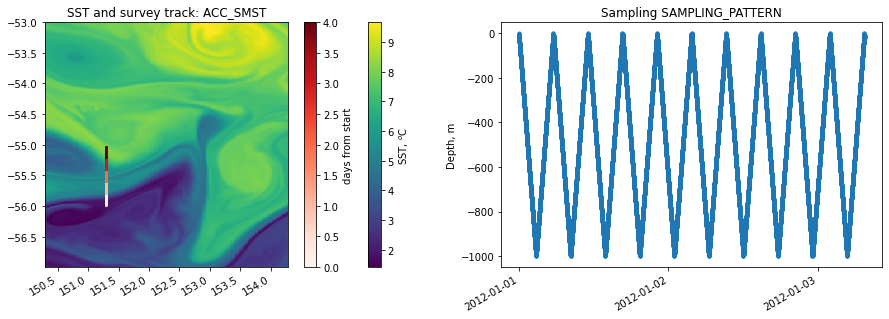

In [10]:
%matplotlib inline
plt.figure(figsize=(15,5))

# map of Theta at time zero
ax = plt.subplot(1,2,1)
ssto = plt.pcolormesh(X,Y,ds.Theta.isel(k=0, time=0).values, shading='auto')
if not (sampling_details['SAMPLING_PLATFORM'] == 'mooring' or sampling_details['SAMPLING_PLATFORM'] == 'sim_mooring'):
    tracko = plt.scatter(survey_track.lon, survey_track.lat, c=(survey_track.time-survey_track.time[0])/1e9/86400, cmap='Reds', s=0.75)
    plt.colorbar(ssto).set_label('SST, $^o$C')
    plt.colorbar(tracko).set_label('days from start')
    plt.title('SST and survey track: ' + RegionName)
else:
    plt.plot(survey_track.lon, survey_track.lat, marker='*', c='r')
    plt.title('SST and mooring location: ' + RegionName + ' region')


# depth/time plot of first few datapoints
ax = plt.subplot(1,2,2)
iplot = slice(0,20000)
if not (sampling_details['SAMPLING_PLATFORM'] == 'mooring' or sampling_details['SAMPLING_PLATFORM'] == 'sim_mooring'):
    plt.plot(survey_track.time.isel(points=iplot), survey_track.dep.isel(points=iplot), marker='.')
else:
    # not quite right but good enough for now.
    # (times shouldn't increase with depth)
    plt.scatter((np.tile(survey_track['time'].isel(time=iplot), int(survey_track['dep'].data.size))),
         np.tile(survey_track['dep'], int(survey_track['time'].isel(time=iplot).data.size)),marker='.')             
# plt.xlim([start_date + datetime.timedelta(days=0), start_date + datetime.timedelta(days=2)])
plt.ylabel('Depth, m')
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
plt.gcf().autofmt_xdate()
plt.title('Sampling SAMPLING_PATTERN')

# save
if SAVE_FIGURES:
    plt.savefig(figdir + filename_base + '_sampling.png', dpi=400, transparent=False, facecolor='white')

plt.show()

### MAIN FUNCTION OF OCEANLINER:
Interpolate data with the specified sampling SAMPLING_PATTERN to create `subsampled_data` then put on a regular grid and store in `sgridded`

In [11]:
%%time
subsampled_data, sgridded = survey_interp(ds, survey_track, survey_indices, sampling_details)
sgridded

Interpolating model fields to the sampling track...
Gridding the interpolated data...
  Theta
  Salt
  vorticity
  steric_height
  U
  V
CPU times: user 11 s, sys: 801 ms, total: 11.8 s
Wall time: 11.7 s


<xarray.Dataset>
Dimensions:             (depth: 999, time: 42)
Coordinates:
  * depth               (depth) float64 -1.0 -2.0 -3.0 ... -997.0 -998.0 -999.0
  * time                (time) datetime64[ns] 2012-01-01 ... 2012-01-05T17:46:20
Data variables: (12/16)
    Theta               (depth, time) float64 1.858 1.94 1.94 ... 2.196 2.196
    Salt                (depth, time) float64 33.81 33.81 33.81 ... 34.64 34.64
    vorticity           (depth, time) float64 -2.273e-05 ... -5.355e-05
    steric_height       (time) float64 0.6043 0.6043 0.6301 ... 0.7538 0.7538
    U                   (depth, time) float64 0.3787 0.7876 ... 0.2273 0.2274
    V                   (depth, time) float64 0.2305 0.02841 ... 0.2608 0.2608
    ...                  ...
    oceTAUX             (time) float64 0.1813 0.1178 0.08026 ... 0.2678 0.321
    oceTAUY             (time) float64 0.111 0.04031 ... -0.05219 -0.07464
    oceFWflx            (time) float64 4.698e-06 9.589e-06 ... -2.615e-05
    oceQnet             (time) float64 -396.8 -585.0 -389.0 ... 202.0 46.24
    oceQsw              (time) float64 -471.7 -662.9 -453.9 ... -0.7889 -103.6
    oceSflux            (time) float64 nan nan nan nan nan ... nan nan nan nan

### Visualizations

Basic plots to show the interpolated variables

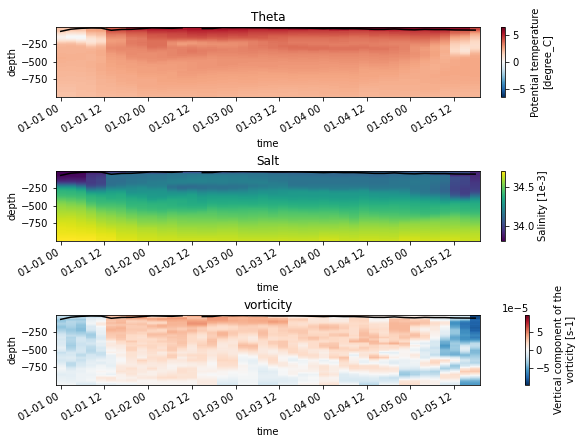

In [12]:
# 3d fields
vbls3d = ['Theta','Salt','U','V','vorticity']
vbls3d = ['Theta','Salt','vorticity']
ylim = [min(sgridded['depth'].values), max(sgridded['depth'].values)]
# ylim = [-200, -1]

nr = len(vbls3d) # # of rows
fig,ax=plt.subplots(nr,figsize=(8,len(vbls3d)*2),constrained_layout=True)


for j in range(nr):
    sgridded[vbls3d[j]].plot(ax=ax[j], ylim=ylim)
    ax[j].plot(sgridded.time.data, -sgridded.KPPhbl.data, c='k')
    ax[j].set_title(vbls3d[j])

if SAVE_FIGURES:
    plt.savefig(figdir + filename_base + '_3D.png', dpi=400, transparent=False, facecolor='white')


In [ ]:
## selected 2d fields
j=0
nr = 6 # # of rows
fig,ax=plt.subplots(nr,figsize=(10,8),constrained_layout=True)


# wind vectors
ax[j].quiver(sgridded.time.data,0,sgridded.oceTAUX.data, sgridded.oceTAUY.data)
ax[j].set_title('Wind stress')    
ax[j].set_ylabel('N m-2')
# SH 
j+=1
ax[j].plot(sgridded.time,sgridded.steric_height-sgridded.steric_height.mean(), 
             sgridded.time.data,sgridded.steric_height_true-sgridded.steric_height_true.mean())
ax[j].set_title('Steric height')
ax[j].legend(['subsampled','true'])
ax[j].set_ylabel('m')

# SSH
j+=1
ax[j].plot(sgridded.time,sgridded.Eta)
ax[j].set_title('SSH')
ax[j].set_ylabel('m')

# MLD
j+=1
ax[j].plot(sgridded.time,sgridded.KPPhbl)
ax[j].set_title('MLD')
ax[j].set_ylabel('m')
ax[j].invert_yaxis()

# surface heat flux
j+=1
ax[j].plot(sgridded.time,sgridded.oceQnet, sgridded.time,sgridded.oceQsw)
ax[j].set_title('Surface heat flux into the ocean')
ax[j].legend(['total','shortwave'])
ax[j].set_ylabel('W m-2')

# surface FW flux
j+=1
ax[j].plot(sgridded.time,sgridded.oceFWflx)
ax[j].set_title('Surface freshwater flux into the ocean') 
ax[j].set_ylabel('kg m-2 s-1')

# horiz line:
for j in range(nr):
    ax[j].axhline(0, color='grey', linewidth=0.8)

if SAVE_FIGURES:
    plt.savefig(figdir + filename_base + '_2D.png', dpi=400, transparent=False, facecolor='white')
   

### Save interpolated data

For both raw and gridded subsampled data, add attributes and save


In [ ]:
# add metadata to attributes
attrs = sampling_details
attrs['start_date'] = start_date.strftime('%Y-%m-%d')
end_date = sgridded['time'].data[-1]
attrs['end_date'] = np.datetime_as_string(end_date,unit='D')
attrs['ndays'] = ndays
attrs.pop('DERIVED_VARIABLES')

In [ ]:
# ------ subsampled data
# this is slow and generates a huge file, so consider skipping
if sampling_parameters['SAMPLING_PLATFORM'] != 'mooring':
    filename_out = filename_out_base + '_subsampled.nc'
    print(f'saving to {filename_out}')
    subsampled_data.attrs = attrs
    netcdf_fill_value = nc4.default_fillvals['f4']
    dv_encoding={'zlib':True,  # turns compression on\
                'complevel':9,     # 1 = fastest, lowest compression; 9=slowest, highest compression \
                'shuffle':True,    # shuffle filter can significantly improve compression ratios, and is on by default \
                'dtype':'float32',\
                '_FillValue':netcdf_fill_value}
    # save to a new file
    # subsampled_data.to_netcdf(filename_out,format='netcdf4',encoding=dv_encoding)
    subsampled_data.to_netcdf(filename_out,format='netcdf4')
    !ls -ltrh {filename_out}

In [ ]:
# ------ gridded:
filename_out = filename_out_base + '_gridded.nc'
print(f'saving to {filename_out}')
sgridded.attrs = attrs
netcdf_fill_value = nc4.default_fillvals['f4']
dv_encoding={'zlib':True,  # turns compression on\
            'complevel':9,     # 1 = fastest, lowest compression; 9=slowest, highest compression \
            'shuffle':True,    # shuffle filter can significantly improve compression ratios, and is on by default \
            'dtype':'float32',\
            '_FillValue':netcdf_fill_value}
# save to a new file
# subsampled_data.to_netcdf(filename_out,format='netcdf4',encoding=dv_encoding)
sgridded.to_netcdf(filename_out,format='netcdf4')
!ls -ltrh {filename_out}

In [ ]:
# ------ gridded:
filename_out = filename_out_base + '_gridded.nc'
print(f'saving to {filename_out}')
sgridded.attrs = attrs
netcdf_fill_value = nc4.default_fillvals['f4']
dv_encoding={'zlib':True,  # turns compression on\
            'complevel':9,     # 1 = fastest, lowest compression; 9=slowest, highest compression \
            'shuffle':True,    # shuffle filter can significantly improve compression ratios, and is on by default \
            'dtype':'float32',\
            '_FillValue':netcdf_fill_value}
# save to a new file
# subsampled_data.to_netcdf(filename_out,format='netcdf4',encoding=dv_encoding)
sgridded.to_netcdf(filename_out,format='netcdf4')
!ls -ltrh {filename_out}


### Visualize interpolated data in 3D

In [ ]:
%matplotlib qt

fig = plt.figure(figsize=(12, 12))
ax = plt.axes(projection='3d')
fig.subplots_adjust(left=0.25, bottom=0.25)

ax.set_xlabel('longitude', fontsize=15, rotation=150)
ax.set_ylabel('latitude',fontsize=15)
ax.set_zlabel('depth', fontsize=15, rotation=60)

p = ax.scatter3D(subsampled_data.lon.data, subsampled_data.lat.data, subsampled_data.dep.data, c=subsampled_data.Theta.data, s=1)
fig.colorbar(p).set_label('Temperature ($^o$C)')
ax.set_title('Temperature interpolated to the survey track')